# MoSDeF: A Molecular Simulation and Design Framework

The Molecular Simulation and Design Framework (MoSDeF) is a collection of open-source tools ([hosted on Github](https://github.com/mosdef-hub)) aimed at facilitating the construction and simulation of complex molecular systems - with a particular focus on the automated screening of large structural parameter spaces. All tools are written as Python packages and feature a Python-based API.

## Basic mBuild tutorial

The first of the MoSDeF tools we will explore is the [mBuild package](http://mosdef-hub.github.io/mbuild/), which utilizes a hierarchical, component-based approach to molecule construction, allowing complex systems to be built using a subset of re-usable parts, just like playing with Legos! In this tutorial we will explore some of mBuild's basic functionality by constructing a linear alkane chain. We'll then examine how mBuild's component-based design approach allows components to be easily swapped to facilitate structural screening.

### Importing mBuild

We first need to import the mBuild package, along with some addition lines of code to help us visualize our molecules in the notebook.

In [1]:
%matplotlib notebook
from visualize import visualize
import mbuild as mb

### The `Compound` class

The base class of mBuild is the `Compound` class, which defines the primary building block used for constructing molecules. Molecules are constructed hierarchically; however, each level of the hierarchy inherits from the `Compound` class. This means that `Compounds` may contain other `Compounds`, and that the same methods and attributes are present for components at any level of the hierarchy.

In [2]:
my_compound = mb.Compound()
type(my_compound)

mbuild.compound.Compound

### Creating `Compounds`

There are several ways that `Compounds` can be created with mBuild. The simplest is to construct them from `Particles`. The `Particle` class is used to define `Compounds` residing at the lowest level of the containment hierarchy. For atomistic systems, `Particle` names should correspond to their elemental symbol (e.g. `'C'`), while for coarse-grained systems `Particle` names should be prefaced by an underscore (e.g. `'_CH4'`).

Here, we will explore this functionality by creating a simple CH2 moiety from two hydrogen `Particles` and a carbon `Particle`. We will begin by creating our empty CH2 `Compound` (to which the `Particles` will be added), along with our three `Particles`.

In [3]:
ch2 = mb.Compound()
carbon = mb.Particle(pos=[0.0, 0.0, 0.0], name='C')
hydrogen = mb.Particle(pos=[0.109, 0.0, 0.0], name='H')
hydrogen2 = mb.Particle(pos=[-0.109, 0.0, 0.0], name='H')

The `add` function is used to add `Compounds` into the containment hierarchy of other `Compounds`. Here, we will add the three `Particles` we just created into the hierarchy of our empty CH2 `Compound`.

<IPython.core.display.Javascript object>


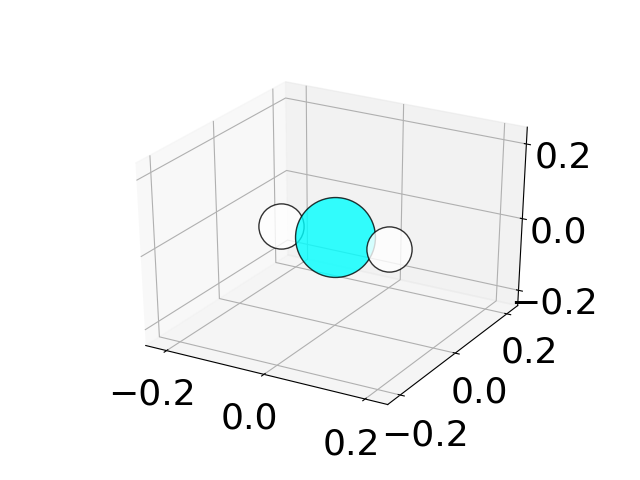

In [4]:
ch2.add([carbon, hydrogen, hydrogen2])
visualize(ch2)

mBuild `Compounds` feature [a variety of useful methods and attributes](http://mosdef-hub.github.io/mbuild/data_structures.html) to facilitate system construction. One of these methods is the `particles()` method, which generates over all `Particles` in a `Compound`.

In [5]:
list(ch2.particles())

[<C pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4538694456>,
 <H pos=( 0.1090, 0.0000, 0.0000), 0 bonds, id: 4538694568>,
 <H pos=(-0.1090, 0.0000, 0.0000), 0 bonds, id: 4538694624>]

Although we've added our three `Particles` to the CH2 `Compound`, we have yet to define any bonds between them. To accomplish this, we can use the `Compound.add_bond()` method to define our two C-H bonds.

<IPython.core.display.Javascript object>


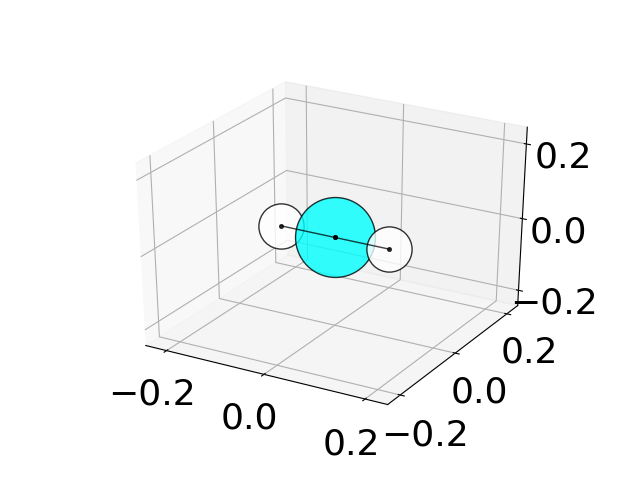

In [6]:
ch2.add_bond((carbon, hydrogen))
ch2.add_bond((carbon, hydrogen2))
visualize(ch2)

While there are instances where creating `Compounds` particle-by-particle is useful, this process can get a bit tedious. It's much easier to create them by loading in pre-assembled building blocks. The `load()` function can create mBuild `Compounds` from a variety of common file formats (e.g. PDB, MOL2). Here, we'll create the same CH2 `Compound` by loading from a PDB file.

<IPython.core.display.Javascript object>


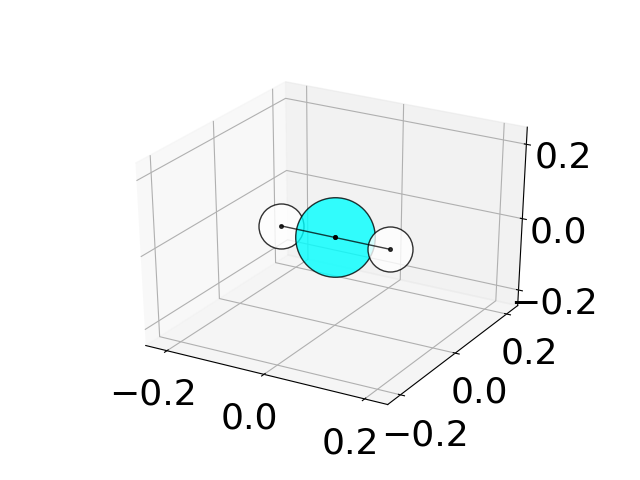

In [7]:
ch2 = mb.load('ch2.pdb')
visualize(ch2)

### Connecting components

While `Particles` can be connected (i.e. bonded) by using the `add_bond` routine, this does not move the atoms in space, and it would become burdensome to manually update the position of each atom. This is where mBuild's [`Port` class](http://mosdef-hub.github.io/mbuild/data_structures.html#mbuild.port.Port) comes into play. `Ports` in the most general sense define a location in space; however, in most cases these can be thought of as dangling bonds. By specifying the `anchor` attribute upon instantiation, a `Port` can be associated with a specific `Particle`, while the `orientation` and `separation` arguments can be used to define the `Port`'s location relative to position of the anchor `Particle`.

<IPython.core.display.Javascript object>


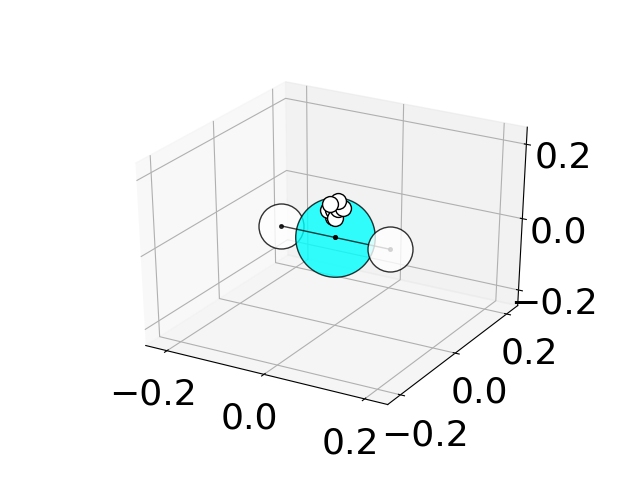

In [8]:
carbon = list(ch2.particles_by_name('C'))[0]
port = mb.Port(anchor=carbon, orientation=[0, 0, 1], separation=0.075)
ch2.add(port, label='up')
visualize(ch2)

The `force_overlap()` function can be used to force the overlap of two `Ports` by performing a coordinate transform on one of the two `Compounds` that should be connected. This will also create a bond between the anchor `Particles` of each `Port`. We'll explore this functionality here by connecting two CH2 groups to create a C2H4 group. Here, we'll also use mBuild's `clone()` function which returns a deep copy of a `Compound`.

<IPython.core.display.Javascript object>


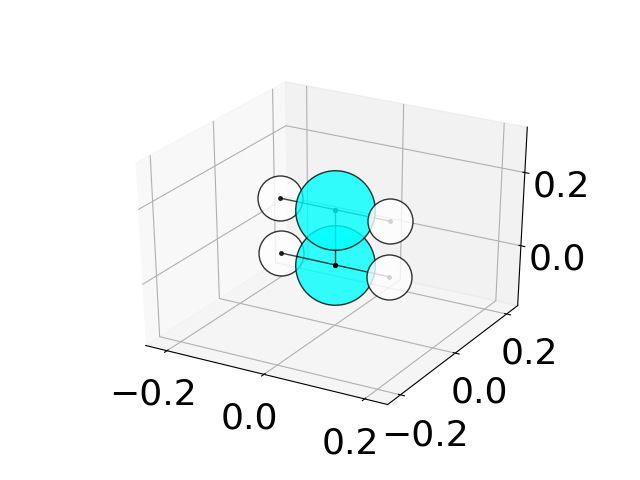

In [9]:
c2h4 = mb.Compound()
ch2_copy = mb.clone(ch2)
mb.force_overlap(move_this=ch2_copy,
                 from_positions=ch2_copy['up'],
                 to_positions=ch2['up'])
c2h4.add((ch2, ch2_copy))
visualize(c2h4)

### Reusable components

mBuild is centered around the idea of reusable components, such that users only need to construct `Compound` building blocks a single time. This is best achieved by defining a class for each building block that inherits from the base `Compound` class. Here, we'll create a class for our CH2 moiety so that we can easily reuse this piece when constructing an alkane chain.

In [10]:
class CH2(mb.Compound):
    def __init__(self):
        super(CH2, self).__init__()
        
        mb.load('ch2.pdb', compound=self)
        carbon = list(self.particles_by_name('C'))[0]
        up_port = mb.Port(anchor=carbon, orientation=[0, 0, 1], separation=0.075)
        down_port = mb.Port(anchor=carbon, orientation=[0, 0, -1], separation=0.075)
        self.add(up_port, label='up')
        self.add(down_port, label='down')

<IPython.core.display.Javascript object>


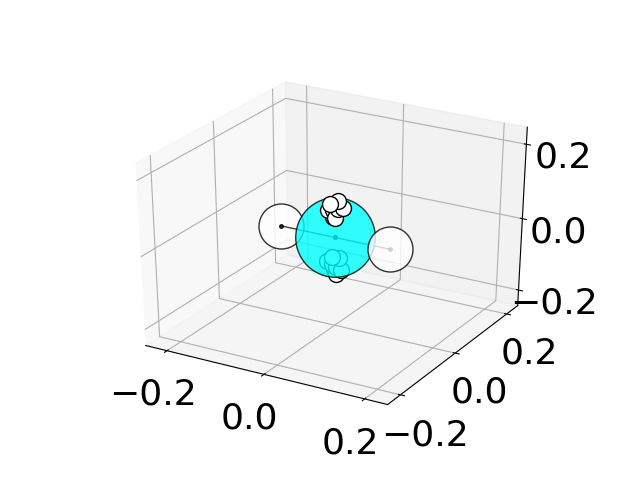

In [11]:
ch2 = CH2()
visualize(ch2)

### Building a linear alkane

Now that we've defined a CH2 building block, we can use this to construct a linear alkane chain. Again we will define a class that inherits from `Compound`. We'll define a class that connects four CH2 units and caps the ends with hydrogen atoms to create a butane molecule. 

In [12]:
class Hydrogen(mb.Compound):
    def __init__(self):
        super(Hydrogen, self).__init__()
        
        self.add(mb.Particle(name='H'))
        up_port = mb.Port(anchor=self[0], orientation=[0, 0, 1], separation=0.075)
        self.add(up_port, 'up')
        

class Butane(mb.Compound):
    def __init__(self):
        super(Butane, self).__init__()
        
        hydrogen = Hydrogen()
        last_unit = CH2()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_unit['up'])
        self.add(last_unit, label='ch2[$]')
        self.add(hydrogen, label='up-cap')
        for _ in range(3):
            current_unit = CH2()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit, label='ch2[$]')
            last_unit=current_unit
        hydrogen = Hydrogen()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_unit['down'])
        self.add(hydrogen, label='down-cap')

<IPython.core.display.Javascript object>


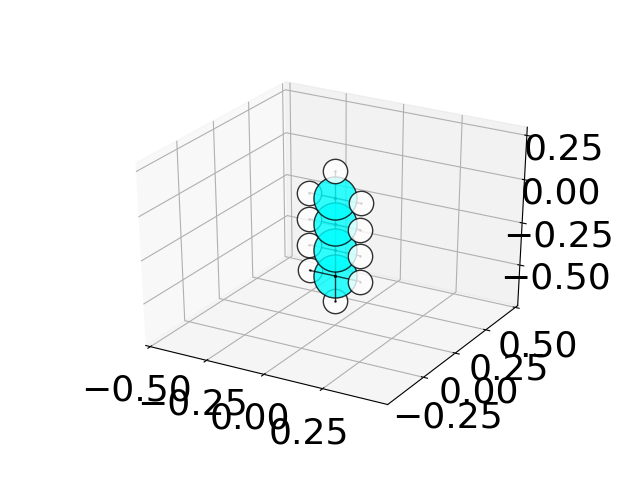

In [13]:
butane = Butane()
visualize(butane)

### Creating flexible classes

If we had to create a new class for each molecule we wanted to examine this would still be quite cumbersome if we wanted to screen over a large structural parameter space. However, since each `Compound` is defined as a Python class, one simply needs to define one or more top-level variables as arguments so that a single class definition could be used to create a whole family of molecules. We'll demonstrate that here by modifying the Butane class we've just defined to allow the creation of any linear alkane by adding a `chain_length` argument.

In [14]:
class Alkane(mb.Compound):
    def __init__(self, chain_length):
        super(Alkane, self).__init__()
        
        hydrogen = Hydrogen()
        last_unit = CH2()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_unit['up'])
        self.add(last_unit, label='ch2[$]')
        self.add(hydrogen, label='up-cap')
        for _ in range(chain_length - 1):
            current_unit = CH2()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit, label='ch2[$]')
            last_unit=current_unit
        hydrogen = Hydrogen()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_unit['down'])
        self.add(hydrogen, label='down-cap')

We can now create any linear alkane by simply providing a different value for `chain_length` upon instantiation.

<IPython.core.display.Javascript object>


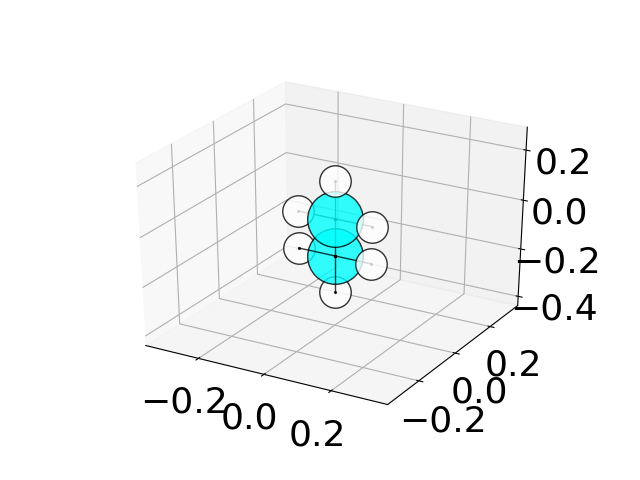

In [15]:
ethane = Alkane(2)
visualize(ethane)

<IPython.core.display.Javascript object>


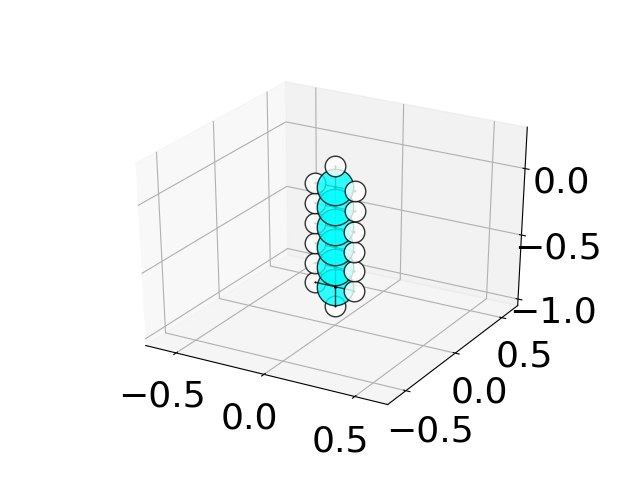

In [16]:
hexane = Alkane(6)
visualize(hexane)

And those are the basics of mBuild! By defining flexible `Compound` classes with several top-level variables, a pool of `Compounds` spanning a large structural parameter space can be created by simply nesting several `for` loops.

<IPython.core.display.Javascript object>


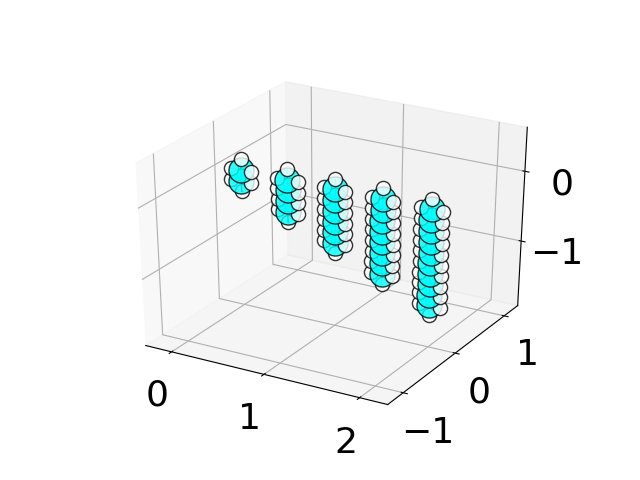

In [17]:
alkanes = mb.Compound()
for chain_length in range(2, 11, 2):
    alkane = Alkane(chain_length=chain_length)
    alkane.translate([len(alkanes.children) / 2, 0 , 0])
    alkanes.add(alkane)
visualize(alkanes)

### Advanced mBuild routines

mBuild contains several routines to perform common operations, such as creating copolymers (essentially a more complex version of the `Alkane` class we defined above) and packing boxes with molecules. We'll explore a few of these here.

#### Creating polymers

<IPython.core.display.Javascript object>


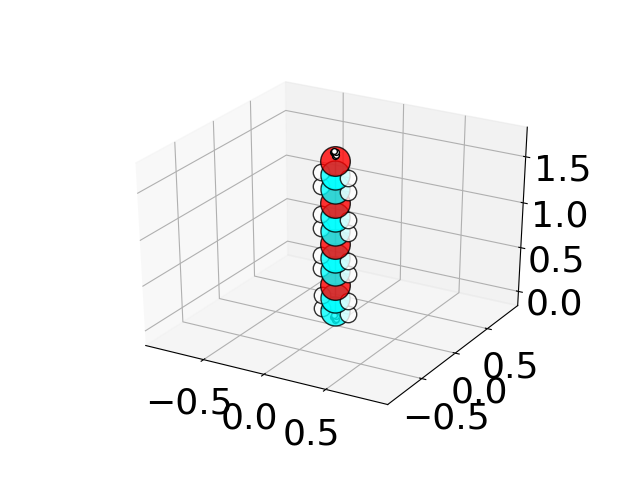

In [18]:
class O(mb.Compound):
    def __init__(self):
        super(O, self).__init__()
        
        self.add(mb.Particle(name='O'))
        up_port = mb.Port(anchor=self[0], orientation=[0, 0, 1], separation=0.075)
        self.add(up_port, 'up')
        down_port = mb.Port(anchor=self[0], orientation=[0, 0, -1], separation=0.075)
        self.add(down_port, 'down')
        
peg4 = mb.Polymer(monomers=(CH2(), O()), n=4, sequence='AAB', port_labels=('up', 'down'))
visualize(peg4)

#### Energy minimization

/Users/summeraz/mbuild/mbuild/compound.py:1256: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  "Open Babel and the {} force field".format(forcefield))
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


<IPython.core.display.Javascript object>


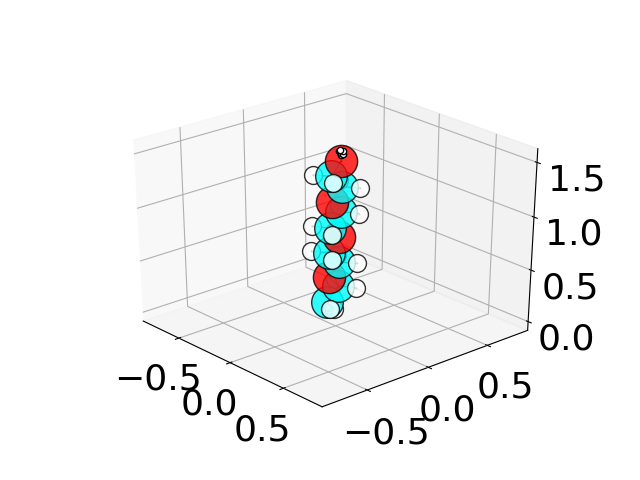

In [19]:
peg4.energy_minimization(steps=5000)
visualize(peg4)

#### Packing

<IPython.core.display.Javascript object>


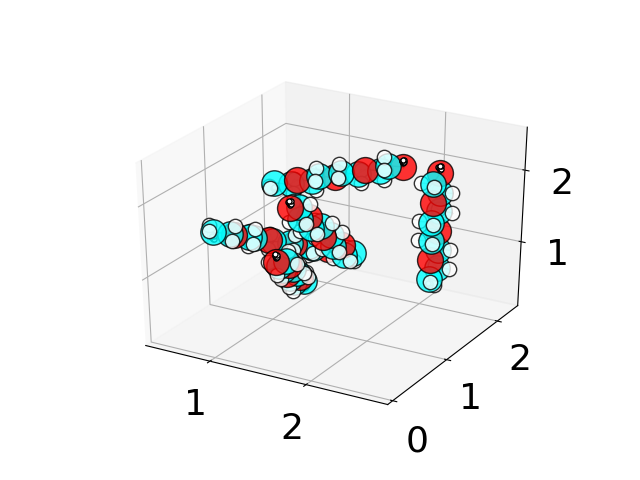

In [20]:
box = mb.fill_box(peg4, n_compounds=5, box=[3, 3, 3])
visualize(box)

#### Surface functionalization

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/mbuild/mbuild/recipes/monolayer.py:80: UserWarning: 
 No fractions provided. Assuming a single chain type.
  warn("\n No fractions provided. Assuming a single chain type.")
/Users/summeraz/mbuild/mbuild/recipes/monolayer.py:83: UserWarning: 
 Adding 100 of chain <Polymer 28 particles, non-periodic, 27 bonds, id: 4712760152>
  warn("\n Adding {} of chain {}".format(len(pattern), chains[-1]))


<IPython.core.display.Javascript object>


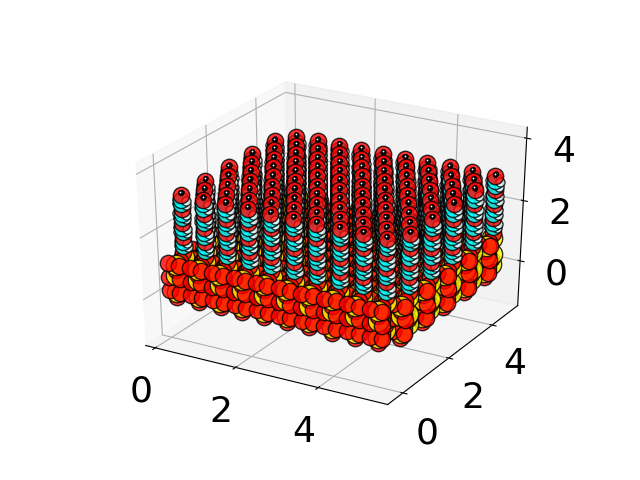

In [21]:
from mbuild.lib.surfaces import Betacristobalite
surface = Betacristobalite()
chain = mb.Polymer(monomers=(CH2(), O()), n=4, sequence='AAB', port_labels=('up', 'down'))
monolayer = mb.Monolayer(surface=surface, chains=chain)
visualize(monolayer)